---
title: "Bayesian Updating: Poisson & Gamma"
author: "Yiğit Aşık"
date: "January 10, 2025"
categories: [Stats, Bayesian, Sports Analytics]
---

The following example is taken from Allen Downey's *Think Bayes*. I believe this is a great one to show how to update priors.

Downey takes a match between France and Crotia, played back in 2018 World Cup, that France won 4-2. Then, he aims to answer two questions:

* How confident we are about France being the better team?
* In a rematch, what is the probability that France would win again?

I'll only attempt to answer the first question so that you have a reason to check Downey's book [*Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap08.html).

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import empiricaldist as emd
import scipy.stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Starting out with certain assumptions:

* There is a goal scoring-rate for every team, goals per game (more specifically, per 90), which we will denote as lambda.
* A goal is equally likely during any minute of the game, regardless of strategy, tempo etc. \
(This is also an assumption under a huge framework in basketball analytics, regularized adjusted plus-minus, wanted to point out just in case you follow my basketball analytics content)
* It isn't possible for a team to score more than once during a single minute.

In [2]:
lam = 1.4 # lambda, goal scoring rate (i.e. goals per game)
dist = st.poisson(lam) # poisson dist. with lambda = 1.4

In [3]:
# probability of scoring "k" goals (4 in this case)
k = 4
dist.pmf(k).round(3) # pmf evaluated at 4.

0.039

So, there's 3.9% chance to observe 4 goals, under the model above.

In [4]:
lam = 1.4 # goal scoring rate
goals = np.arange(10) # possible values for goals
probas = st.poisson(lam).pmf(goals)

probas

array([2.46596964e-01, 3.45235750e-01, 2.41665025e-01, 1.12777012e-01,
       3.94719540e-02, 1.10521471e-02, 2.57883433e-03, 5.15766866e-04,
       9.02592015e-05, 1.40403202e-05])

Text(0, 0.5, 'PMF')

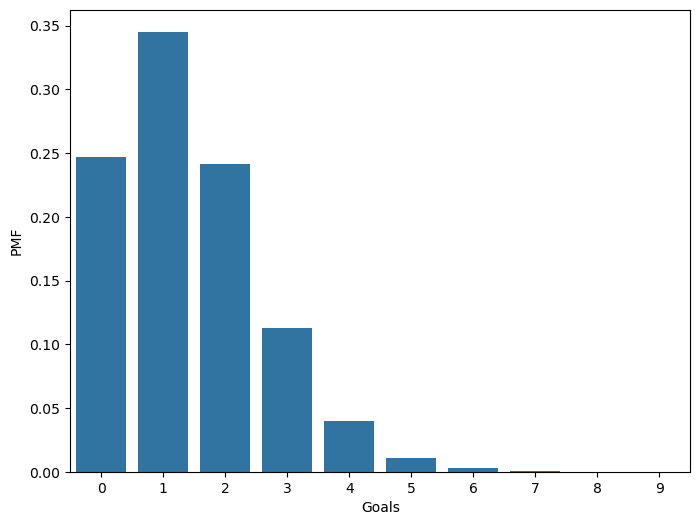

In [5]:
fig = plt.figure(figsize=(8,6))
g = sns.barplot(x=goals, y=probas)

g.set_xlabel('Goals')
g.set_ylabel('PMF')

Let's try to move the other way around: Estimate the goal-scoring rate from given goals.

Downey has used data from previous World Cups to estimate that the each team scores 1.4 goals per game, approximately. Hence, it is reasonable to make mean of lambda 1.4.

The goal scoring rate is continuous and it can't take values below 0, hence a distribution that reflects this features would be great: Gamma distribution. Additionally, it's easy to construct one since it only takes one parameter which is the mean which we already have value for.

In [6]:
alpha = 1.4 # mean of the distribution
lams = np.linspace(0, 10, 101) # possible values of lam between 0 and 10
ps = st.gamma(alpha).pdf(lams) # probability densities

In [7]:
prior = emd.Pmf(ps, lams)
prior.normalize() # Pmf offers "normalize" method, which divides by the total probability of the data (i.e., probability under any parameter/hypothesis)

9.889360237140306

In [8]:
df_prior = pd.DataFrame(prior.ps, prior.qs).rename(columns={0:'probas'})

Text(0.5, 0, 'Goals')

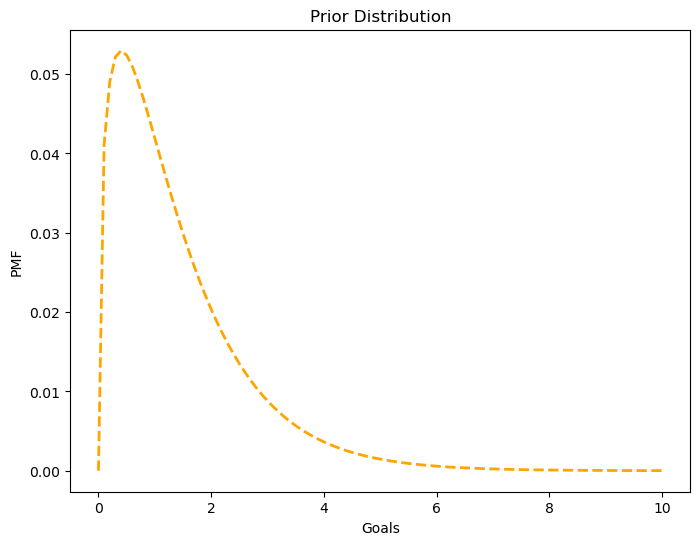

In [9]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_prior.index, y=df_prior.probas, color='orange', linestyle='--', linewidth=2)

g.set_title('Prior Distribution')
g.set_ylabel('PMF')
g.set_xlabel('Goals')

In [10]:
np.sum(df_prior.index * df_prior.probas) # mean of the distribution

1.4140818156118378

### Updating with new data

So, our initial belief for France's goal scoring rate (in this example, for other teams as well), goals per 90 mins, was 1.4. Then we observed 4 goals from France, should we still think that France's goal scoring rate is 1.4? If not, how much should it change?

In [11]:
lambdas = lams # different lambdas (different goal scoring rates)
k = 4 # observed data
likelihood = st.poisson(lambdas).pmf(k) # for each lambda (for each parameter), how likely we are to see 4 goals
likelihood[:4]

array([0.00000000e+00, 3.77015591e-06, 5.45820502e-05, 2.50026149e-04])

In [12]:
df_prior['likelihood'] = likelihood
df_prior.head(4)

,probas,likelihood
0.000,0.000,0.000
0.100,0.041,0.000
0.200,0.049,0.000
0.300,0.052,0.000


In [13]:
p_norm = emd.Pmf(df_prior['probas'] * df_prior['likelihood'], df_prior.index)
p_norm.normalize()

0.05015532557804499

In [14]:
df_prior['posterior'] = p_norm

Text(0.5, 1.0, 'France')

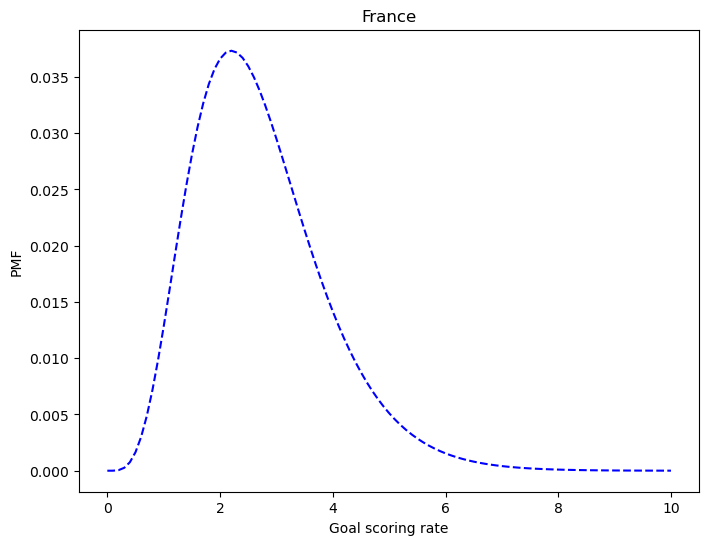

In [15]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_prior.index, y=df_prior.posterior, color='blue', linestyle='--')

g.set_xlabel('Goal scoring rate')
g.set_ylabel('PMF')
g.set_title('France')

Same steps for Crotia:

In [16]:
df_crotia = df_prior[['probas']].copy()
df_crotia.head(3)

,probas
0.000,0.000
0.100,0.041
0.200,0.049


In [17]:
k = 2 # Crotia's number of goals in the match
likelihood_cro = st.poisson(lams).pmf(2)
likelihood_cro[:4]

array([0.        , 0.00452419, 0.01637462, 0.03333682])

In [18]:
df_crotia['likelihood'] = likelihood_cro

In [19]:
p_norm = emd.Pmf(df_crotia['probas'] * df_crotia['likelihood'], df_crotia.index)
p_norm.normalize()

0.1609321178598705

In [20]:
df_crotia['posterior'] = p_norm

Text(0.5, 1.0, 'Crotia')

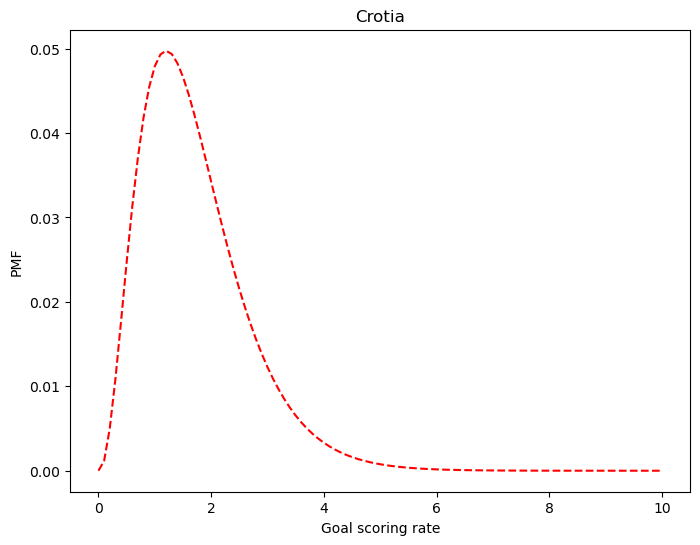

In [21]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_crotia.index, y=df_crotia['posterior'], color='red', linestyle='--')

g.set_xlabel('Goal scoring rate')
g.set_ylabel('PMF')
g.set_title('Crotia')

How confident we are that France is the better team?

In [22]:
print(
    'Mean of France: ', str(np.sum(df_prior.index * df_prior.posterior).round(1)), '\n'
    'Mean of Crotia: ', str(np.sum(df_crotia.index * df_crotia.posterior).round(1))
)

Mean of France:  2.7 
Mean of Crotia:  1.7


Text(0.5, 1.0, 'France vs Crotia')

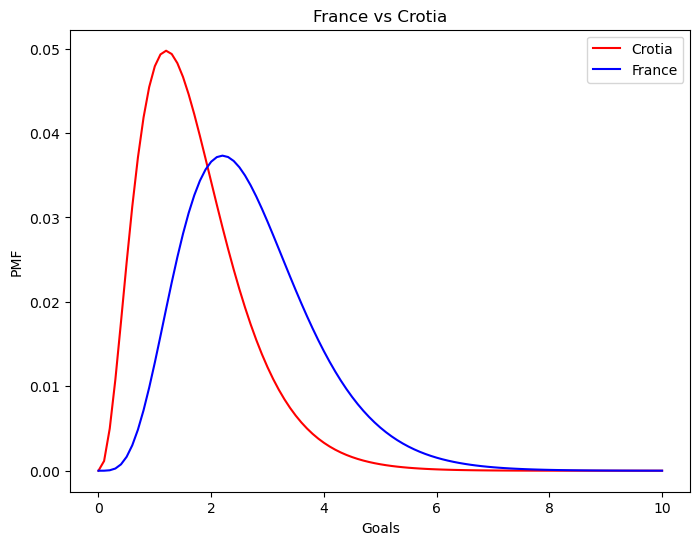

In [23]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_crotia.index, y=df_crotia['posterior'], color='red', label='Crotia')
g = sns.lineplot(x=df_prior.index, y=df_prior['posterior'], color='blue', label='France')

g.set_xlabel('Goals')
g.set_ylabel('PMF')
g.set_title('France vs Crotia')

Probability of superiority is a way to express an *effect size*. Here's a great visualization tool that you can play with to make expression of effect sizes more intuitive: [Interpreting Effect Sizes: An Interactive Visualization](https://rpsychologist.com/cohend/)

In [25]:
# Probability of superiority.

france_proba = 0

for i in df_prior.index.tolist():
    for j in df_crotia.index.tolist():
        if i > j:
            france_proba += df_prior.loc[i, 'posterior'] * df_crotia.loc[j, 'posterior']
        else:
            continue

france_proba.round(2)

0.75

Probability of superiority feels very intuitive: It is the probability of randomly sampled lambda for France being higher than randomly sampled lambda for Crotia. If there isn't much overlap between two distributions, we are more confident that the one group (in this example, a team) is higher/lower than the other: Probability of superiority reflects that. You can use any tool (Python, R etc.) to simulate this, and I highly suggest it if you are not currently able to wrap your head around. Just generate different distributions and play with the idea.

I didn't include but there is one more reason why we used poisson and gamma distributions, it is related to something called [*conjugates*](https://www.sciencedirect.com/topics/computer-science/conjugate-prior) that I first came across while I was going through Daniel Lakens' [Improving Your Statistical Inferences: Bayesian statistics](https://lakens.github.io/statistical_inferences/04-bayes.html). They make things computationally more feasible compared to the *grid* approach here.

Examples (like this one) from many books can be found on my [GitHub repo](https://github.com/YigitAsik/learn-stats-with-sims), and I highly suggest you to go through Allen Downey's books. Have a nice weekend.